# Robustness Test
I will attempt to demonstrate that DNNs can be trained such that their performance is robust to noisy activations. 

During training, I will perturb activations with Gaussian noise that is < 10% the amplitude of the weights. Then at test time, I will test the model on different perturbations of the weights. 

In [1]:
%matplotlib inline
import IPython.display

import gzip
import cPickle as pickle
import pandas as pd
import random
import seaborn
import librosa
import sklearn
import numpy as np
from matplotlib import pyplot as plt

# Keras Imports
from keras.layers import Input, Dense, Lambda 
from keras.layers import Flatten, Reshape, Layer
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import GaussianNoise
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical

from keras import metrics
from sklearn.utils import shuffle
from scipy.stats import norm

from librosa.display import waveplot, specshow
seaborn.set(style='ticks')
# seaborn.set(style='white')

Using TensorFlow backend.


## Data Visualization

In [2]:
# Loaded Spoken Digits Dataset
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)  

File loaded as ../SpokenDigitDB.pkl.gz


In [3]:
# df.groupby('Class')
# df['Class'] = df.Class.

In [4]:
# Padding & Truncating
maxlen = 84
pad    = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.min(a[:])*np.ones([a.shape[0],n - a.shape[1]])))
df.Magnitude = df.Magnitude.apply(pad,args=(maxlen,))  # MaxLen Truncation Voodoo :D
print(np.unique([np.shape(x)[1] for x in df.Magnitude]))

[84]


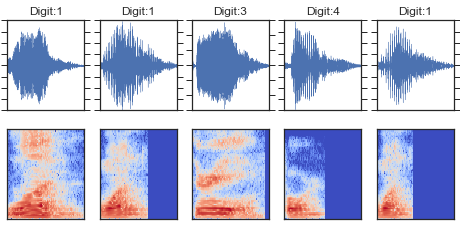

In [5]:
# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,sidx)    

for i,j in enumerate(sidx):
    if i<k:
        plt.subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        plt.title('Digit:{1}'.format(j,df.Class[j]))
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().get_xaxis().set_visible(False)

    else:
        plt.subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])     

In [6]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## Data Preparation

In [7]:
# Prepare Data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split

# Train Scaler
x_data = df.Magnitude.values
normsc = np.hstack(x_data)
scaler = MinMaxScaler().fit(normsc.T)

# Transform Data using Scaler
x_data = [scaler.transform(arr.T).T for arr in df.Magnitude.values]
x_data = np.dstack(x_data).transpose(2,0,1)

# Add Singleton
x_data = x_data[...,None]         # Add singleton class
y_data = to_categorical(df.Class.cat.codes)

# Shuffle & Split
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,
                              test_size=0.33, random_state=32)

# Print Dimensions
print 'Training Feature size:', x_train.shape
print 'Training Target  size:', y_train.shape
print ''
print 'Testing  Feature size:', x_test.shape
print 'Testing  Target  size:', y_test.shape

Training Feature size: (3021, 64, 84, 1)
Training Target  size: (3021, 10)

Testing  Feature size: (1488, 64, 84, 1)
Testing  Target  size: (1488, 10)


## ConvNet Model

In [8]:
# Parameters
chns, rows, cols = 1, 64, 84
img_size = (rows,cols,chns)

In [9]:
# Model
x     = Input(shape=img_size)
conv1 = Conv2D(16,(3,5),name='C1',padding='same',activation='relu',strides=(2,2))(x)
conv2 = Conv2D(16,(3,3),name='C2',padding='same',activation='relu',strides=(2,2))(conv1)
conv3 = Conv2D(16,(3,3),name='C3',padding='same',activation='relu')(conv2)
avgpl = AveragePooling2D((4,4))(conv3)
flatn = Flatten()(avgpl)
y     = Dense(10,name='Classifier',activation='softmax')(flatn)


network = Model(x,y)
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 84, 1)         0         
_________________________________________________________________
C1 (Conv2D)                  (None, 32, 42, 16)        256       
_________________________________________________________________
C2 (Conv2D)                  (None, 16, 21, 16)        2320      
_________________________________________________________________
C3 (Conv2D)                  (None, 16, 21, 16)        2320      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
Classifier (Dense)           (None, 10)                3210      
Total para

In [10]:
# Train Model
log1=network.fit(x_train,y_train,
            shuffle=True,
            epochs=20,
            batch_size=32,
            validation_split=0.3,
            verbose=2,
            callbacks=[TensorBoard(log_dir='/tmp/robustcnn')])

Train on 2114 samples, validate on 907 samples
Epoch 1/20
2s - loss: 2.1758 - acc: 0.1944 - val_loss: 1.8338 - val_acc: 0.3219
Epoch 2/20
2s - loss: 1.4302 - acc: 0.5255 - val_loss: 0.9029 - val_acc: 0.7365
Epoch 3/20
2s - loss: 0.7278 - acc: 0.7644 - val_loss: 0.5650 - val_acc: 0.7960
Epoch 4/20
2s - loss: 0.4895 - acc: 0.8387 - val_loss: 0.3672 - val_acc: 0.8842
Epoch 5/20
2s - loss: 0.3058 - acc: 0.9130 - val_loss: 0.2203 - val_acc: 0.9283
Epoch 6/20
2s - loss: 0.2355 - acc: 0.9238 - val_loss: 0.2791 - val_acc: 0.8986
Epoch 7/20
2s - loss: 0.1866 - acc: 0.9461 - val_loss: 0.2236 - val_acc: 0.9184
Epoch 8/20
2s - loss: 0.2292 - acc: 0.9395 - val_loss: 0.1339 - val_acc: 0.9625
Epoch 9/20
2s - loss: 0.1232 - acc: 0.9683 - val_loss: 0.1087 - val_acc: 0.9691
Epoch 10/20
2s - loss: 0.1091 - acc: 0.9669 - val_loss: 0.0938 - val_acc: 0.9702
Epoch 11/20
2s - loss: 0.1092 - acc: 0.9674 - val_loss: 0.1048 - val_acc: 0.9735
Epoch 12/20
2s - loss: 0.0883 - acc: 0.9787 - val_loss: 0.0974 - val_ac

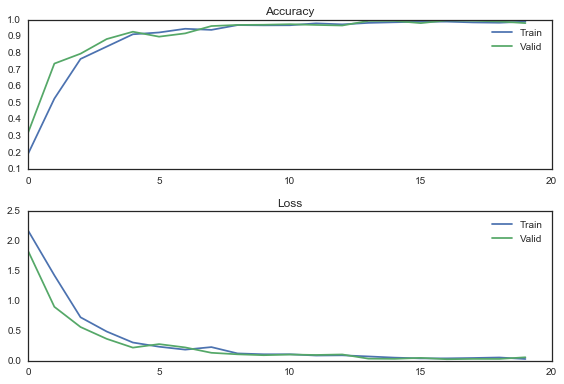

In [19]:
seaborn.set(style='white')
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(log1.epoch,log1.history['acc'])
ax1.plot(log1.epoch,log1.history['val_acc'])
ax1.set_title('Accuracy')
ax1.legend(['Train','Valid'])

ax2.plot(log1.epoch,log1.history['loss'])
ax2.plot(log1.epoch,log1.history['val_loss'])
ax2.set_title('Loss')
ax2.legend(['Train','Valid'])

plt.tight_layout()

## Evaluation

In [12]:
y_scr = network.predict(x_test)
y_prd = np.argmax(y_scr,-1)
y_tst = np.argmax(y_test,-1)

acc = sklearn.metrics.accuracy_score(y_tst,y_prd)
print "Testing accuracy: %.2f"%(acc*100)
print ''
print sklearn.metrics.confusion_matrix(y_tst,y_prd)

Testing accuracy: 97.24

[[145   0   0   0   0   0   0   0   0   0]
 [  0 111   0   0   2   1   0   0   0  20]
 [  0   0 143   0   0   0   0   1   0   0]
 [  0   0   0 153   0   0   0   0   0   0]
 [  0   0   0   0 139   0   0   0   0   0]
 [  0   0   0   0   0 141   0   0   0   3]
 [  0   0   0   0   0   0 166   1   0   0]
 [  0   0   0   0   0   6   1 150   0   0]
 [  0   0   0   1   0   0   2   0 152   0]
 [  2   0   0   0   0   1   0   0   0 147]]


----

# Network Trained with Noise
What we want to do is replace all activations, say: $$g(x) = \tanh(x)$$ with $$\hat{g}(x) = a \tanh(bx) + c$$

where $a$, $b$ and $c$ are Normally distributed variables. 

The multiplicative and additive variables $a$ and $c$ can be easily obtained by perturbing layer activations using samples from a normal distribution. 

The variable $b$ is a little tricky. It is a multiplicative term for the inputs to each layer. For each layer, this is a multiplier to the previous layer's activations. Since we're already perturbing activations in all layers, we are indirectly doing this $b$ multiplier. Hence, I posit it's not necessary to explicitly define $b$. 

I proceed to build the noisy network below:

In [13]:
# Create Layer for Additive & Multiplicative Noise
stdev_mul = 0.01
stdev_add = 0.01

mean_mul  = 1.0
mean_add  = 0.0

def Gnoise(x):
    g    = x * K.random_normal(shape=K.shape(x),
                               mean=mean_mul,stddev=stdev_mul)
    return g + K.random_normal(shape=K.shape(x),
                               mean=mean_add,stddev=stdev_add)

In [14]:
# Model
nx     = Input(shape=img_size)
ng     = Lambda(Gnoise,name='GnX')(nx)
nconv1 = Conv2D(16,(3,5),name='nC1',padding='same',activation='relu',strides=(2,2))(ng)
nconv1 = Lambda(Gnoise,name='Gn1')(nconv1)
nconv2 = Conv2D(16,(3,3),name='nC2',padding='same',activation='relu',strides=(2,2))(nconv1)
nconv2 = Lambda(Gnoise,name='Gn2')(nconv2)
nconv3 = Conv2D(16,(3,3),name='nC3',padding='same',activation='relu')(nconv2)
nconv3 = Lambda(Gnoise,name='Gn3')(nconv3)
navgpl = AveragePooling2D((4,4))(nconv3)
nflatn = Flatten()(navgpl)
ny     = Dense(10,name='nClassifier',activation='softmax')(nflatn)
ny     = Lambda(Gnoise,name='GnY')(ny)

noisynet = Model(nx,ny)
noisynet.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
noisynet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 84, 1)         0         
_________________________________________________________________
GnX (Lambda)                 (None, 64, 84, 1)         0         
_________________________________________________________________
nC1 (Conv2D)                 (None, 32, 42, 16)        256       
_________________________________________________________________
Gn1 (Lambda)                 (None, 32, 42, 16)        0         
_________________________________________________________________
nC2 (Conv2D)                 (None, 16, 21, 16)        2320      
_________________________________________________________________
Gn2 (Lambda)                 (None, 16, 21, 16)        0         
_________________________________________________________________
nC3 (Conv2D)                 (None, 16, 21, 16)        2320      
__________

In [15]:
# Train Model
log2=noisynet.fit(x_train,y_train,
            shuffle=True,
            epochs=20,
            batch_size=32,
            validation_split=0.3,
            verbose=2,
            callbacks=[TensorBoard(log_dir='/tmp/noisycnn')])

Train on 2114 samples, validate on 907 samples
Epoch 1/20
5s - loss: 2.1502 - acc: 0.1878 - val_loss: 1.7549 - val_acc: 0.3749
Epoch 2/20
5s - loss: 1.3398 - acc: 0.5596 - val_loss: 1.2415 - val_acc: 0.5810
Epoch 3/20
4s - loss: 0.8069 - acc: 0.7337 - val_loss: 0.5816 - val_acc: 0.7993
Epoch 4/20
5s - loss: 0.6612 - acc: 0.8032 - val_loss: 0.5435 - val_acc: 0.8148
Epoch 5/20
5s - loss: 0.4658 - acc: 0.8694 - val_loss: 0.3573 - val_acc: 0.9008
Epoch 6/20
5s - loss: 0.8714 - acc: 0.7947 - val_loss: 0.7876 - val_acc: 0.8346
Epoch 7/20
5s - loss: 0.5153 - acc: 0.8477 - val_loss: 0.3373 - val_acc: 0.8897
Epoch 8/20
4s - loss: 0.3038 - acc: 0.9096 - val_loss: 0.3219 - val_acc: 0.8765
Epoch 9/20
5s - loss: 0.2905 - acc: 0.9044 - val_loss: 0.2368 - val_acc: 0.9140
Epoch 10/20
4s - loss: 0.2569 - acc: 0.9272 - val_loss: 0.1994 - val_acc: 0.9471
Epoch 11/20
5s - loss: 0.2436 - acc: 0.9328 - val_loss: 0.1927 - val_acc: 0.9305
Epoch 12/20
5s - loss: 0.2511 - acc: 0.9177 - val_loss: 0.1883 - val_ac

In [16]:
y_scr = noisynet.predict(x_test)
y_prd = np.argmax(y_scr,-1)
y_tst = np.argmax(y_test,-1)

acc = sklearn.metrics.accuracy_score(y_tst,y_prd)
print "Testing accuracy: %.2f"%(acc*100)
print ''
print sklearn.metrics.confusion_matrix(y_tst,y_prd)

Testing accuracy: 96.30

[[145   0   0   0   0   0   0   0   0   0]
 [  0 132   0   0   0   1   0   0   0   1]
 [  0   0 143   0   0   0   0   1   0   0]
 [  0   0   0 153   0   0   0   0   0   0]
 [  1   0   0   0 136   2   0   0   0   0]
 [  0   2   0   0   0 135   0   2   0   5]
 [  2   0   0   4   0   0 161   0   0   0]
 [  1   1   0   1   0  13   0 141   0   0]
 [  0   0   0   4   0   0   0   0 151   0]
 [  5   8   0   0   0   0   0   1   0 136]]


## Conclusion
Looks like the network performs well even with the noisy perturbations: **as long as the additive and multiplicative noise is kept under 0.05 standard deviations**. 

Actually, the noisy training seems to perform better than regular training when the standard deviation is kept at **0.01**. 

In [17]:
# Distribution of Layer Weights
[w,b] = noisynet.layers[2].get_weights()

print "Mean of weights: %.4f"%(w.mean())
print "Stdv of weights: %.4f"%(w.std())
print ""
print "Mean of biases:  %.4f"%(b.mean())
print "Stdv of biases:  %.4f"%(b.std())

Mean of weights: 0.0709
Stdv of weights: 0.1210

Mean of biases:  -0.0219
Stdv of biases:  0.1669


In [22]:
pd.DataFrame({'Accuracy_Baseline':   log1.history['acc'],
              'Loss_Baseline':       log1.history['loss'],
              'Accuracy_NoisyModel': log2.history['acc'],
              'Loss_NoisyModel':     log2.history['loss']}).to_csv('train_curves.csv')

In [ ]:
dfd = pd.DataFrame({})